notebook: 1.3.-becker-data-modelling-XGBoost.ipynb

author: Jonathan Becker  

**Updated:** 2025-12-11
**Purpose:** Train XGBoost Model with binary target (0=1, 1=[1,2,3]) to see if a binary classification results in better model scores. 
**Summary:** This notebook trains the XGBoost model with same preprocessing and model parameters as 1.2-becker-data-modelling-XGBoost.ipynb. But instead of a multiclass target, its a binary one. 



In [67]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os
# make custom libraries importable
import sys
sys.path.append('../../library')

# pipeline compatibel classes
#from road_accidents_pipeline import ModalityReducer              # bundle classes of categorical features together to higher-tier classes to reduce dimensionality
#from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation
from road_accidents_pipeline import TrigonometricEncoder         # encoding for cyclic variables lice acc_month or acc_hour
from road_accidents_pipeline import SafeColumnSelector           # makes sure only to use existing columns in pipeline

# scaler
from sklearn.preprocessing import MinMaxScaler

# encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.decomposition import PCA
#from sklearn.inspection import permutation_importance

import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# model classifier
from sklearn.ensemble import RandomForestClassifier

# hyperparameter optimization
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# little helper
from cleaning_utils import distinguish_cols
import time

# XGBoost classifier
from xgboost import XGBClassifier
# google cloud storage
import gc_storage as gcs


from google.cloud import storage

In [37]:
# init Google Cloud storage
bucket_name='sep25-bds-road-accidents'
key_path='../../auth/fiery-glass-478009-t8-18a81c8cbe63.json'

bucket = gcs.init_bucket( bucket=bucket_name,
                                 json_key_path=key_path )
gcs.list_bucket( bucket=bucket,
                 remote_folder='2_preprocessing' )

Initialized sep25-bds-road-accidents
Number of blobs: [35]
data/processed/2_preprocessing/
data/processed/2_preprocessing/0.1-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.2-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.3-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.4-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/1.0-becker-data-preprocessing_usagers.joblib
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.gc
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_vehicles.joblib
data/processed/2_preprocessing/1.0-munz-acc-municipality_X_test_uniques_lookup_table.gc
data/processed/2_preprocessing/1.0-munz-acc-municipality_X_train_uniques_lookup_table.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-X_test.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-X_test_proce

In [38]:
df = gcs.download( bucket=bucket,
                   remote_path='2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib')

Downloaded data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib to
 ../../data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib


In [39]:
# 
# Split data into features and target
X = df.drop(columns=['ind_severity'], axis=1)
y = df['ind_severity']

print("Original target distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True).round(3))

# Remap target: 1 = not injured -> 0, 2/3/4 = injured  or dead-> 1
y_binary = (y > 1).astype(int)

print("After remapping:", np.unique(y_binary))
print(pd.Series(y_binary).value_counts())
print(y_binary.value_counts(normalize=True).round(3))

Original target distribution:
ind_severity
1    285859
2    280987
3    106958
4     18355
Name: count, dtype: int64
ind_severity
1    0.413
2    0.406
3    0.155
4    0.027
Name: proportion, dtype: float64
After remapping: [0 1]
ind_severity
1    406300
0    285859
Name: count, dtype: int64
ind_severity
1    0.587
0    0.413
Name: proportion, dtype: float64


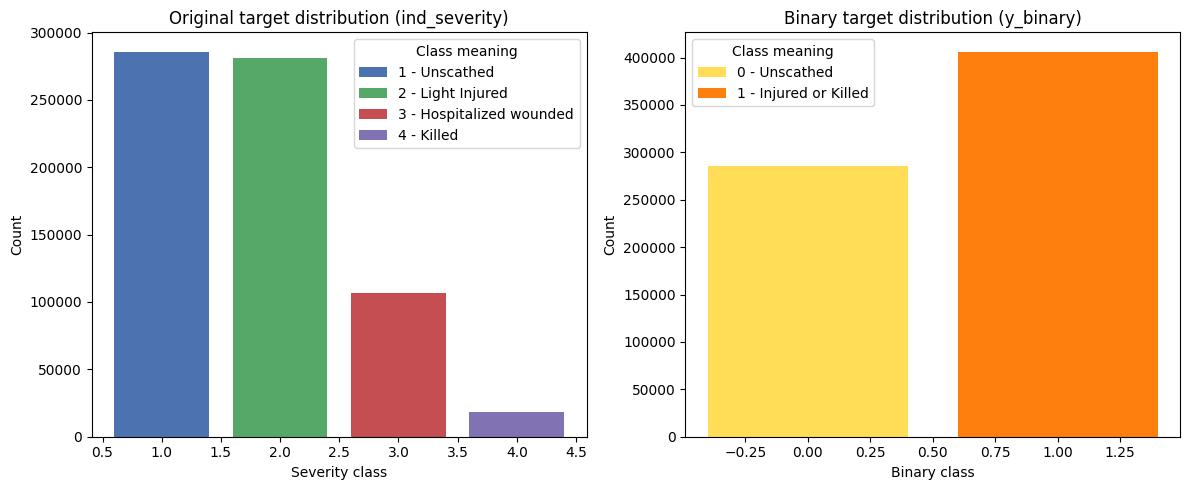

In [76]:


# Original target
X = df.drop(columns=['ind_severity'], axis=1)
y = df['ind_severity']

# Binary remap
y_binary = (y > 1).astype(int)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original distribution
y_counts = y.value_counts().sort_index()
labels_orig = [
    "1 - Unscathed",
    "2 - Light Injured",
    "3 - Hospitalized wounded",
    "4 - Killed"
]
colors_orig = ["#4c72b0", "#55a868", "#c44e52", "#8172b3"]
bars_orig = axes[0].bar(y_counts.index, y_counts.values, color=colors_orig)
axes[0].set_title("Original target distribution (ind_severity)")
axes[0].set_xlabel("Severity class")
axes[0].set_ylabel("Count")
axes[0].legend(bars_orig, labels_orig, title="Class meaning")

# Binary distribution
y_bin_counts = pd.Series(y_binary).value_counts().sort_index()
labels_bin = [
    "0 - Unscathed",
    "1 - Injured or Killed"
]
colors_bin = ["#ffdd57", "#ff7f0e"]
bars_bin = axes[1].bar(y_bin_counts.index, y_bin_counts.values, color=colors_bin)
axes[1].set_title("Binary target distribution (y_binary)")
axes[1].set_xlabel("Binary class")
axes[1].set_ylabel("Count")
axes[1].legend(bars_bin, labels_bin, title="Class meaning")

plt.tight_layout()
plt.savefig("../../models/target_distributions.png", dpi=300, bbox_inches="tight")
plt.show()



In [40]:
# train test split with stratification 
X_train, X_test, y_train, y_test = train_test_split( X, y_binary,
                                                     test_size=0.3,
                                                     random_state=123,
                                                     stratify=y_binary)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (484511, 44)
y_train shape: (484511,)
X_test shape: (207648, 44)
y_test shape: (207648,)


In [41]:
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                    591
ind_secu2                 193635
ind_location              218905
ind_action                198293
acc_ambient_lightning          8
acc_atmosphere                28
acc_intersection              20
acc_collision_type          2684
veh_impact                   199
veh_maneuver               27962
loca_road_lanes             6830
loca_road_view                45
loca_road_surface_cond        89
loca_max_speed              6677
loca_max_speed_dif          6677
dtype: int64


In [42]:
mapping_dicts = {
    "acc_ambient_lightning": {
        1: 1,  # day
        2: 2,  # twilight
        3: 3, 4: 3, 5: 3  # night
    },

    "acc_intersection": {
        1: 1,  # no intersection
        2: 2, 3: 2, 4: 2,  # simple / standard intersection
        6: 3,  # roundabout
        5: 4, 7: 4, 8: 4, 9: 4  # other
    },

    "acc_atmosphere": {
        1: 1,  # clear
        2: 2, 3: 2,  # rainy
        8: 3,  # cloudy
        4: 4, 5: 4, 6: 4, 7: 4, 9: 4  # adverse / special
    },

    "acc_collision_type": {
        1: 1,  # frontal
        2: 2,  # rear
        3: 3,  # side
        4: 4, 5: 4, 6: 4, 7: 4  # multi / chain / other
    },

    "ind_place": {
        1: 1,  # driver
        **{i: 2 for i in range(2, 10)},  # passenger
        10: 3  # pedestrian / external
    },

    "ind_cat": {
        1: 1,  # driver
        2: 2,  # passenger
        3: 3, 4: 3  # pedestrian
    },

    "ind_sex": {
        1: 1,  # male
        2: 2,  # female
        -1: 2  # female (wrong/missing recoded)
    },

    "ind_trip": {
        1: 1, 2: 1,  # commuting
        3: 2,  # shopping
        4: 3,  # professional
        5: 4,  # leisure
        0: 5, 9: 5  # other
    },

    "ind_secu1": {
        0: 0,  # no equipment
        1: 1,  # seatbelt
        2: 2,  # helmet
        3: 3, 4: 3, 9: 3,  # other / child / vest
        8: 4, -1: 4  # unknown / not reported
    },

    "veh_cat": {
        10: 1, 7: 1,  # light vehicles (car)
        2: 2, 31: 2, 32: 2, 34: 2, 35: 2, 36: 2, 41: 2, 42: 2, 43: 2, 33: 2, 30: 2,  # 2-wheeler
        80: 3, 1: 3,  # bicycle / E-bike
        13: 4, 15: 4, 38: 4, 39: 4, 40: 4, 14: 4, 37: 4,  # heavy / public vehicles
        60: 5, 50: 5,  # micromobility (EDP)
        3: 6, 0: 6, 17: 6, 99: 6, 16: 6, 20: 6, 21:6  # other
    },

    "veh_fixed_obstacle": {
        3: 1, 7: 1, 9: 1, 10: 1, 11: 1, 12: 1, 14: 1, 15: 1, 16: 1, 1: 1, 2: 1, 4: 1, 5: 1, 6: 1,  # vehicle / barrier / wall
        8: 2, 13: 2, 17: 2,  # pole / ditch / culvert
        0: 0  # no fixed obstacle
    },

    "veh_moving_obstacle": {
        1: 1,  # pedestrian
        2: 2,  # vehicle
        4: 3, 5: 3, 6: 3, 9: 3,  # other
        0: 0  # none
    },

    "veh_impact": {
        1: 1, 2: 1, 3: 1,  # front
        4: 2, 5: 2, 6: 2,  # rear
        7: 3, 8: 3,  # side
        9: 4,  # multiple / roll-over
        0: 0  # no impact
    },

    "veh_maneuver": {
        1: 1, 2: 1,  # straight / same lane
        9: 2, 11: 2, 13: 2, 12: 2, 14: 2,  # lane change / offset
        15: 3, 16: 3,  # turning
        5: 4, 17: 4, 19: 4, 18: 4,  # risky maneuvers
        23: 5,  # stopped
        26: 6, 98: 6, 99: 6, 4: 6, 10: 6, 20: 6, 22: 6, 24: 6, 3: 6, 6: 6, 7: 6, 8: 6, 21: 6, 25: 6,  # other maneuvers
        0: 0  # unknown
    },

    "veh_motor": {
        -1: 0, 0: 0,  # missing / unknown
        1: 1, 2: 1,  # combustion / hybrid
        3: 2, 4: 2, 6: 2,  # electric / alt-power
        5: 3  # human-powered
    },

    # keep as is
    "loca_road_cat": {
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
        6: 6,
        7: 7,
        8: 8    
    },

    # keep as is
    "loca_traffic_circul": {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4                      
    },

    "loca_road_gradient": {
        0: 0,       # unknown / missing
        1: 1, 2: 1, # flat / slope
        3: 2, 4: 2  # top / bottom
    },

    "loca_road_view": {
        0: 0,       # unknown
        1: 1,       # straight
        2: 2, 3: 2, # curve
        4: 3        # s-shape
    },

    "loca_road_surface_cond": {
        0: 0, 9: 0,                         # unknown / other
        1: 1, 2: 1,                         # typical (normal / wet)
        3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2  # hazardous (water / snow / mud / ice / oil)
    },

    "loca_accident": {
        0: 0,       # none / unknown
        1: 1, 2: 1, # on roadway
        3: 2,       # roadside (verge)
        4: 3, 5: 3, # pedestrian areas
        6: 4, 7: 4  # other special lanes
    },

  
}

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
class ModalityReducer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to reduce categorical modalities
    using predefined mapping dictionaries.
    """

    def __init__(self, mapping_dicts=None):
        self.mapping_dicts = mapping_dicts if mapping_dicts is not None else {}

    def fit(self, X, y=None):
        # Nothing to learn, just return self
        return self

    def transform(self, X):
        X = X.copy()

        # Apply mappings for categorical variables
        for col, mapping in self.mapping_dicts.items():
            if col in X.columns:
                X[col] = X[col].map(mapping).fillna(X[col])

        return X

In [44]:
X.columns

Index(['acc_num', 'ind_place', 'ind_cat', 'ind_sex', 'ind_trip', 'ind_secu1',
       'ind_secu2', 'ind_location', 'ind_action', 'ind_year', 'ind_age',
       'ind_age_group', 'acc_date', 'acc_year', 'acc_month', 'acc_hour',
       'acc_department', 'acc_municipality', 'acc_metro', 'acc_long',
       'acc_lat', 'acc_ambient_lightning', 'acc_atmosphere',
       'acc_urbanization_level', 'acc_intersection', 'acc_collision_type',
       'veh_cat', 'veh_fixed_obstacle', 'veh_moving_obstacle', 'veh_impact',
       'veh_maneuver', 'veh_motor', 'veh_id', 'loca_road_cat',
       'loca_traffic_circul', 'loca_road_lanes', 'loca_road_gradient',
       'loca_road_view', 'loca_road_surface_cond', 'loca_accident',
       'loca_max_speed', 'loca_is_intersection', 'loca_road_counts',
       'loca_max_speed_dif'],
      dtype='object')

In [45]:
class RemoveIrrelevantCols(BaseEstimator, TransformerMixin):
    """
    Transformer to remove unnecessary columns from the road accidents DataFrame.
    If a column does not exist, it will be ignored and a warning printed.
    """

    def __init__(self, cols_to_drop=None, verbose=True):
        # Default columns to drop if none provided
        if cols_to_drop is None:
            cols_to_drop = [
    
    "acc_num", 
    "veh_id", 
    "acc_date", 
    "acc_long", 
    "acc_lat",
    "acc_department",
     "acc_year", 
     "ind_year", 
     "ind_age",
    "acc_metro", 
    "ind_secu2", 
    "ind_location", 
    "ind_action",
    "loca_road_counts", 
    "loca_max_speed_dif", 
    "loca_is_intersection"
]
        self.cols_to_drop = cols_to_drop
        self.verbose = verbose
        self._feature_names_out = None

    def fit(self, X, y=None):
        # Store the feature names that remain after dropping
        if isinstance(X, pd.DataFrame):
            self._feature_names_out = [
                col for col in X.columns if col not in self.cols_to_drop
            ]
        return self

    def transform(self, X):
        # Ensure input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        missing_cols = [col for col in self.cols_to_drop if col not in X.columns]
        if missing_cols and self.verbose:
            print("ℹ️ RemoveIrrelevantCols -> The following columns were not found and skipped:", missing_cols)

        return X.drop(columns=[col for col in self.cols_to_drop if col in X.columns])

    def get_feature_names_out(self, input_features=None):
        # Return stored feature names if available
        if self._feature_names_out is not None:
            return self._feature_names_out
        # Fallback: drop cols from input_features
        if input_features is not None:
            return [col for col in input_features if col not in self.cols_to_drop]
        raise ValueError("Feature names are not available. Fit the transformer first.")


In [46]:
# -------------------------------------------------------------------------------------------------
# define columns to be operated: read in columns from dictionary for later use in pipeline
# -------------------------------------------------------------------------------------------------
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict

ohe_cols = [
        'acc_urbanization_level','acc_collision_type', 
        'ind_cat','ind_secu1','ind_sex',
        'veh_cat','veh_fixed_obstacle','veh_moving_obstacle','veh_maneuver',"ind_place", "ind_trip", "ind_age_group",
            "acc_ambient_lightning", "acc_atmosphere", "acc_intersection",
            "veh_impact", "veh_motor", "loca_road_cat", "loca_traffic_circul",
            "loca_road_gradient", "loca_road_view", "loca_road_surface_cond",
            "loca_accident"
    ]

⚠️ Missing columns (ignored): ['loca_road_count']


In [47]:
# -------------------------------------------------------------------------------------------------
# Full preprocessing pipeline
# -------------------------------------------------------------------------------------------------
# steps:
# --------------------------------------------------------
# - RemoveIrrelevantCols: Drops columns not useful for prediction.
# - ConditionalMultiQuantImputer: Imputes missing numeric values based on road category.
# - ConditionalCatImputer: Fills missing categorical values conditionally on target distribution.
# - AggrLocaSplit: Aggregates location features for intersections.
# - RemoveIdCols: Removes identifier columns used in aggregation.
# - RearrangeCatCols: merge some classes in veh categorical columns to reduce cardinatliy.
# - ColumnTransformer: Applies cyclic encoding, one-hot, CatBoost encoding, and scaling to features.


# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'), columns=["acc_municipality"])
cyclical_transformer = TrigonometricEncoder({"acc_hour": 24, "acc_month": 12})

# instantiate Scaler
#scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),
    ("remove_id_cols", RemoveIdCols(verbose=True)),
    ("modality_reducer", ModalityReducer(mapping_dicts=mapping_dicts)),

    # imputing
    ("impute_quant", ConditionalMultiQuantImputer(
        quant_vars=["loca_max_speed"], cat_var="loca_road_cat")),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),
 
    # encoding & scaling
    ("encode_scale", ColumnTransformer([
        # cyclical encoding
        ("cyclical", cyclical_transformer, ["acc_hour", "acc_month"]),  

        # one-hot encoding
        ("onehot", Pipeline([
            ("select", SafeColumnSelector(ohe_cols)),
            ("encode", ohe_encoder)
        ]), ohe_cols),

        # catboost encoding
        ("catboost", catboost_encoder, ["acc_municipality"]),

       

        # keep numeric remainder features as float
        ("numeric", "passthrough", ["loca_max_speed", "loca_road_lanes"])
    ], remainder="drop"))   # drop everything else
    
], verbose=True)


# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# # Access the fitted aggregation step
# aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# # Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error)
# y_train_piped = aggr_step.transform_y(X_train, y_train)
# y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")

[Pipeline] ....... (step 1 of 6) Processing remove_cols, total=   0.1s
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id', 'acc_num']
[Pipeline] .... (step 2 of 6) Processing remove_id_cols, total=   0.0s
[Pipeline] .. (step 3 of 6) Processing modality_reducer, total=   0.3s
[Pipeline] ...... (step 4 of 6) Processing impute_quant, total=   4.7s
ℹ️ ConditionalCatImputer -> Column 'acc_year' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'loca_is_intersection' not found, skipping.
[Pipeline] ........ (step 5 of 6) Processing impute_cat, total=   0.8s
[Pipeline] ...... (step 6 of 6) Processing encode_scale, total=   1.9s
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id', 'acc_num']
ℹ️ RemoveIdCols -> The follo

In [48]:
# check shape of pipeline output
#--------------------------------------------------------
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)
X_train_piped_df.info(max_cols=132)
X_test_piped_df = pd.DataFrame(X_test_piped, columns=feature_names)
# check shape of pipeline output
#--------------------------------------------------------
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)
X_test_piped_df = pd.DataFrame(X_test_piped, columns=feature_names)
X_train_piped_df = X_train_piped_df.astype(float)
X_test_piped_df = X_test_piped_df.astype(float)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484511 entries, 0 to 484510
Data columns (total 103 columns):
 #    Column                              Non-Null Count   Dtype  
---   ------                              --------------   -----  
 0    cyclical__acc_hour_sin              484511 non-null  float64
 1    cyclical__acc_hour_cos              484511 non-null  float64
 2    cyclical__acc_month_sin             484511 non-null  float64
 3    cyclical__acc_month_cos             484511 non-null  float64
 4    onehot__acc_urbanization_level_1    484511 non-null  float64
 5    onehot__acc_urbanization_level_2    484511 non-null  float64
 6    onehot__acc_collision_type_1.0      484511 non-null  float64
 7    onehot__acc_collision_type_2.0      484511 non-null  float64
 8    onehot__acc_collision_type_3.0      484511 non-null  float64
 9    onehot__acc_collision_type_4.0      484511 non-null  float64
 10   onehot__ind_cat_1                   484511 non-null  float64
 11   onehot__ind

In [49]:
# --------------------------------------------------------------------------------------------------
# modelling with pipeline
# --------------------------------------------------------------------------------------------------
# Start timer
start_time = time.time()
class_counts = np.bincount(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]   # majority / minority
# pipeline with XGBClassifier
model_pipeline = ImbPipeline([
    #('under', RandomUnderSampler(random_state=42)),
    #('over', RandomOverSampler(random_state=42)),    
    ('clf', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        random_state=42,
        n_jobs=-1,
        objective="binary:logistic", # here changed for binary
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight, # added 
    ))
])



# parameter grid for RandomizedSearchCV
param_dist = {
    "clf__max_depth": [4, 6, 8],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.7, 0.8, 1.0],
    "clf__colsample_bytree": [0.7, 0.8, 1.0],
    "clf__reg_alpha": [0, 0.1, 1, 5, 10],} # added in attempt 3 for reducing for feature selection 
   
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

search.fit(X_train_piped_df, y_train)
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)
best_xgb = search.best_estimator_.named_steps["clf"]
y_test_pred_best = best_xgb.predict(X_test_piped_df)
y_train_pred_best = best_xgb.predict(X_train_piped_df)
y_test_proba = best_xgb.predict_proba(X_test_piped_df)[:, 1]


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ model fitting completed in {elapsed_minutes:.2f} minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=6, clf__reg_alpha=5, clf__subsample=0.8; total time= 1.1min
[CV] END clf__colsample_bytree=0.7, clf__learning_rate=0.05, clf__max_depth=6, clf__reg_alpha=5, clf__subsample=0.8; total time= 1.1min
[CV] END clf__colsample_bytree=0.7, clf__learning_rate=0.05, clf__max_depth=6, clf__reg_alpha=5, clf__subsample=0.8; total time= 1.1min
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=6, clf__reg_alpha=5, clf__subsample=0.8; total time= 1.1min
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=8, clf__reg_alpha=1, clf__subsample=1.0; total time= 1.3min
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=8, clf__reg_alpha=1, clf__subsample=1.0; total time= 1.3min
[CV] END clf__colsample_bytree=0.7, clf__learning_rate=0.01, clf__max_depth=8, clf__reg_alpha=0.1, clf__subsample=0.7; total 

In [50]:
# evalution
print("Train Report:\n", classification_report(y_train, y_train_pred_best))
print("Test Report:\n", classification_report(y_test, y_test_pred_best))

print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred_best))

Train Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80    200101
           1       0.89      0.80      0.84    284410

    accuracy                           0.83    484511
   macro avg       0.82      0.83      0.82    484511
weighted avg       0.83      0.83      0.83    484511

Test Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77     85758
           1       0.86      0.78      0.82    121890

    accuracy                           0.80    207648
   macro avg       0.79      0.80      0.79    207648
weighted avg       0.81      0.80      0.80    207648

Confusion Matrix (Test):
 [[70753 15005]
 [27101 94789]]


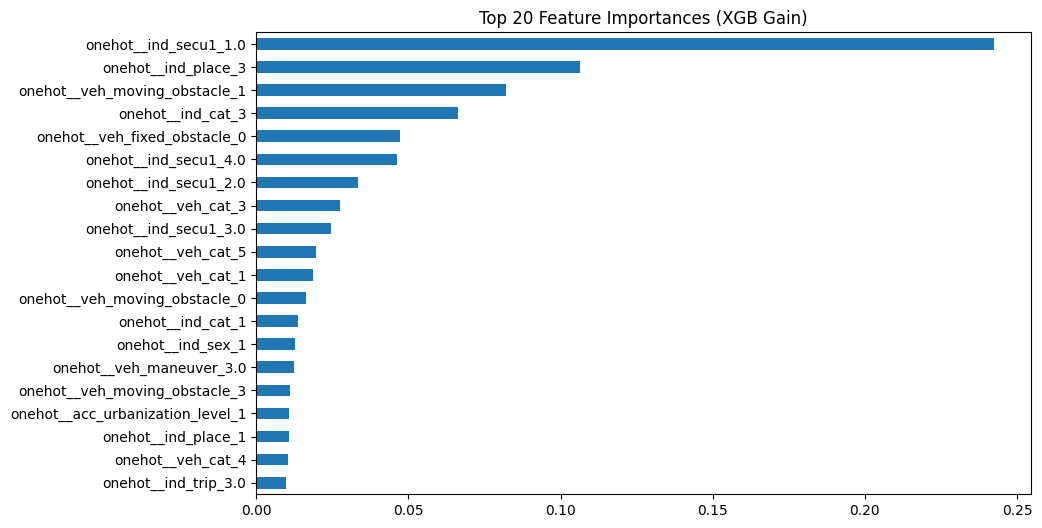

In [51]:
importances = best_xgb.feature_importances_
feat_imp = pd.Series(importances, index=X_train_piped_df.columns)

# Top 20 Features
top20 = feat_imp.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
top20.plot(kind="barh")
plt.title("Top 20 Feature Importances (XGB Gain)")
plt.gca().invert_yaxis()
plt.show()

In [52]:
# handling missing values for PCA
print(X_train_piped_df.isna().sum().sort_values(ascending=False).head(20))
X_train_final = X_train_piped_df.fillna(0)

numeric__loca_road_lanes        6830
onehot__veh_impact_1.0             0
onehot__loca_road_cat_3            0
onehot__loca_road_cat_2            0
onehot__loca_road_cat_1            0
onehot__veh_motor_3                0
onehot__veh_motor_2                0
onehot__veh_motor_1                0
onehot__veh_motor_0                0
onehot__veh_impact_4.0             0
onehot__veh_impact_3.0             0
onehot__veh_impact_2.0             0
onehot__veh_impact_0.0             0
onehot__loca_road_cat_5            0
onehot__acc_intersection_4.0       0
onehot__acc_intersection_3.0       0
onehot__acc_intersection_2.0       0
onehot__acc_intersection_1.0       0
onehot__acc_atmosphere_4.0         0
onehot__acc_atmosphere_3.0         0
dtype: int64


/var/folders/wg/yhq9d1yx1t1cjky0l7l0d6040000gn/T/ipykernel_52262/3971350343.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", n_classes)


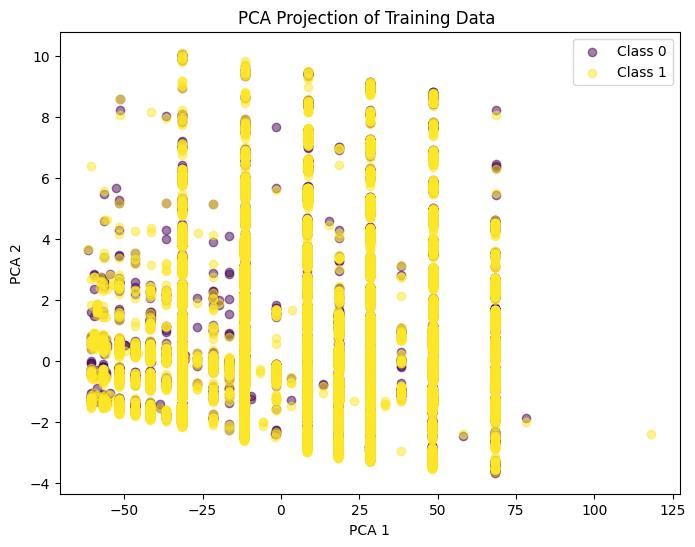

In [63]:
# PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_final)

# define colors
n_classes = len(np.unique(y_train))
cmap = plt.cm.get_cmap("viridis", n_classes)

plt.figure(figsize=(8,6))
for i, cls in enumerate(np.unique(y_train)):
    plt.scatter(
        X_pca[y_train==cls, 0],
        X_pca[y_train==cls, 1],
        label=f"Class {cls}",
        alpha=0.5,
        color=cmap(i)
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection of Training Data ")
plt.legend()
plt.show()


In [54]:
# Extract feature importances
importances = best_xgb.feature_importances_
features = X_train_final.columns

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top 20
print("Top 20 XGB Features by Importance:")
print(importance_df.head(20))

()
plt.show()

Top 20 XGB Features by Importance:
                             Feature  Importance
14             onehot__ind_secu1_1.0    0.242528
41               onehot__ind_place_3    0.106258
30     onehot__veh_moving_obstacle_1    0.082231
12                 onehot__ind_cat_3    0.066404
26      onehot__veh_fixed_obstacle_0    0.047092
17             onehot__ind_secu1_4.0    0.046394
15             onehot__ind_secu1_2.0    0.033409
22                 onehot__veh_cat_3    0.027498
16             onehot__ind_secu1_3.0    0.024435
24                 onehot__veh_cat_5    0.019588
20                 onehot__veh_cat_1    0.018808
29     onehot__veh_moving_obstacle_0    0.016210
10                 onehot__ind_cat_1    0.013659
18                 onehot__ind_sex_1    0.012650
35          onehot__veh_maneuver_3.0    0.012536
32     onehot__veh_moving_obstacle_3    0.011002
4   onehot__acc_urbanization_level_1    0.010824
39               onehot__ind_place_1    0.010739
23                 onehot__veh_cat

# 1 ()
ohe_cols = [
        'acc_urbanization_level','acc_collision_type', 
        'ind_cat','ind_secu1','ind_sex',
        'veh_cat','veh_fixed_obstacle','veh_moving_obstacle','veh_maneuver']
Train Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80    200101
           1       0.89      0.80      0.84    284410

    accuracy                           0.82    484511
   macro avg       0.82      0.83      0.82    484511
weighted avg       0.83      0.82      0.83    484511

Test Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77     85758
           1       0.86      0.78      0.82    121890

    accuracy                           0.80    207648
   macro avg       0.79      0.80      0.79    207648
weighted avg       0.81      0.80      0.80    207648

Confusion Matrix (Test):
 [[70816 14942]
 [27103 94787]]

 # 2
 ohe_cols = [
        'acc_urbanization_level','acc_collision_type', 
        'ind_cat','ind_secu1','ind_sex',
        'veh_cat','veh_fixed_obstacle','veh_moving_obstacle','veh_maneuver',"ind_place", "ind_trip", "ind_age_group",
            "acc_ambient_lightning", "acc_atmosphere", "acc_intersection",
            "veh_impact", "veh_motor", "loca_road_cat", "loca_traffic_circul",
            "loca_road_gradient", "loca_road_view", "loca_road_surface_cond",
            "loca_accident"
    ]
    Train Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80    200101
           1       0.89      0.80      0.84    284410

    accuracy                           0.83    484511
   macro avg       0.82      0.83      0.82    484511
weighted avg       0.83      0.83      0.83    484511

Test Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77     85758
           1       0.86      0.78      0.82    121890

    accuracy                           0.80    207648
   macro avg       0.79      0.80      0.79    207648
weighted avg       0.81      0.80      0.80    207648

Confusion Matrix (Test):
 [[70753 15005]
 [27101 94789]]
 # 3
 

In [71]:
dump(best_xgb, "xgb_binary.joblib")

['xgb_binary.joblib']